In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from aidino.detector import Detector
from aidino.sample import Crystal
from aidino.diffraction import BraggCoherentDiffraction
from aidino.beam import GaussianBeam

In [2]:
dtype = torch.float32
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(dtype)

In [10]:
wavelength = 1.68e-10

detector = Detector(
    num_pixels_i = 1024,
    num_pixels_j = 1024,
    pixel_size = 75e-6,
    distance = 1.,
    wavelength = wavelength,
    dtype = dtype,
    device = device
)
resolution = detector.calculate_resolution()
print(f'Detector resolution (ΔX): {resolution:.2g} m')

crystal = Crystal(
    'cifs/BaTiO3.cif',
    crystal_size = (256,256,32),
    wavelength = wavelength,
    include_anomalous = True,
    dtype = dtype,
    device = device
)

lengths = crystal.lattice_vectors.norm(dim=1)
print('Crystal size:', ' nm x '.join('{:.1f}'.format(crystal.crystal_size[i] * lengths[i] * 1e9) for i in range(len(lengths))), 'nm')

simulator = BraggCoherentDiffraction(
    crystal = crystal,
    dtype = dtype,
    device = device
)

Detector resolution (ΔX): 2.2e-09 m
Crystal size: 102.6 nm x 102.6 nm x 12.8 nm


In [11]:
crystal.visualize_structure()

Display size reduced to (43, 43, 5) to stay within 50,000 atom display limit.
Visualizing crystal of size (43, 43, 5) (46225 atoms)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

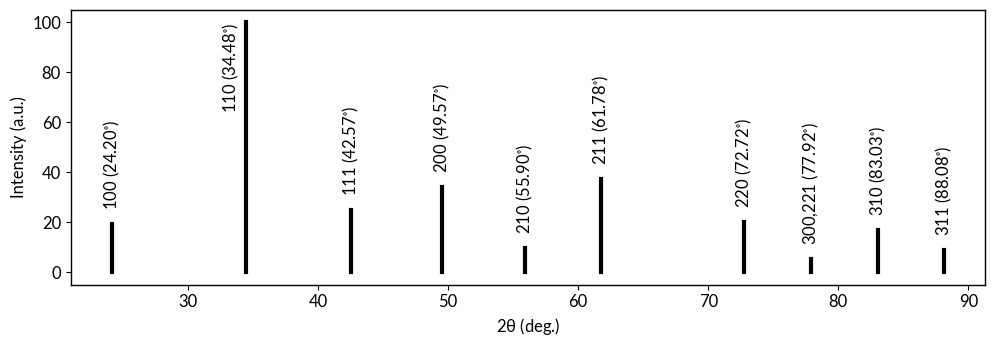

In [12]:
fig = crystal.get_xrd_pattern()

In [13]:
crystal.list_reflections()

  h   k   l     2θ (degrees)
-----------------------------------
  1   0   0        24.197530
  1   1   0        34.484886
  1   1   1        42.573221
  2   0   0        49.567547
  2   1   0        55.896544
  2   1   1        61.782058
  2   2   0        72.716357
  3   0   0        77.922177
  2   2   1        77.922177
  3   1   0        83.028370
  3   1   1        88.079335
-----------------------------------
Total reflections: 11


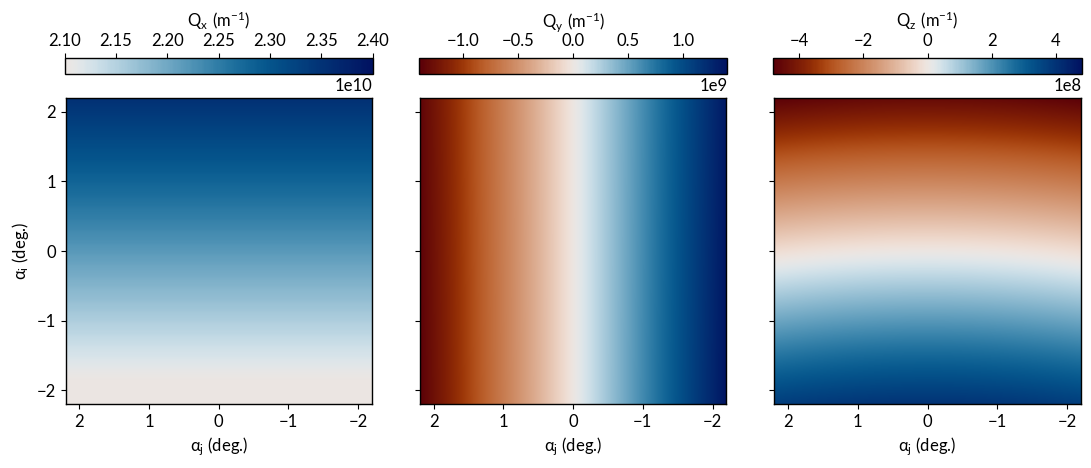

In [20]:
crystal.align_miller_plane_to_axis((1,1,0), target_axis='x')

theta_B = torch.deg2rad(torch.tensor(34.484886 / 2., dtype=dtype, device=device))
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0.0, torch.cos(theta_B)], dtype=dtype, device=device)

q_vectors = detector.calculate_q_vectors(k_i, k_f)
fig = detector.plot_q_vectors(q_vectors)

In [21]:
# Require that supercell approximation remains below experiment resolution, i.e. d_i * a_i < ΔX
print('ΔX:', ','.join('{:d}'.format(int(resolution / lengths[i].item())) for i in range(len(lengths))), 'cells')
print('ΔX^3:', '{:d}'.format(np.prod([int(resolution / lengths[i].item()) for i in range(len(lengths))])), 'cells')
print('Oversampling ratio:', detector.calculate_oversampling_ratio(crystal.crystal_volume).item())

ΔX: 5,5,5 cells
ΔX^3: 125 cells
Oversampling ratio: 21.83308219909668


In [22]:
supercell_size = (4,4,4)
q_batch_size = 512

In [23]:
beam = GaussianBeam(
    wavelength = wavelength,
    fwhm = 50e-9
)

beam.create_profile(
    crystal = crystal,
    supercell_size = supercell_size,
    k_i = k_i
)

Auto beam entry: -z face in lab frame → crystal axis c (- direction), 
Beam_center: (128.0, 128.0, 2.0)


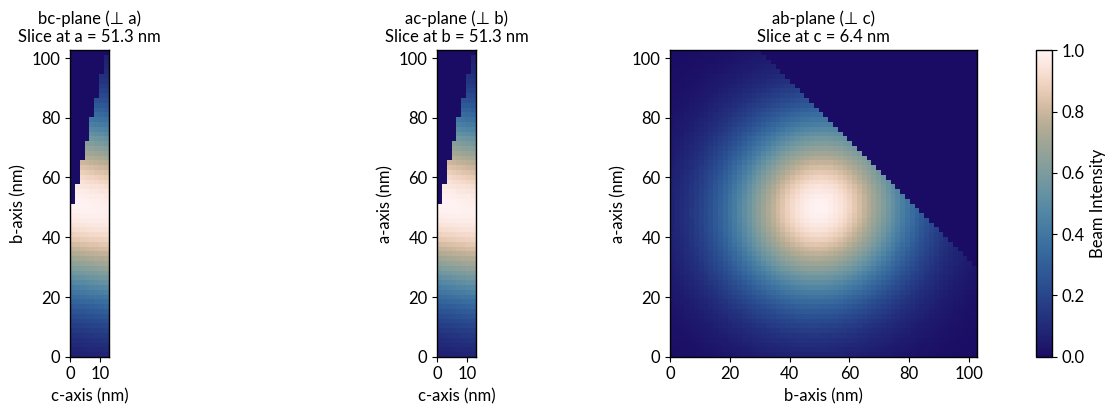

In [24]:
fig = beam.plot_profile(
    crystal = crystal,
    supercell_size = supercell_size
)

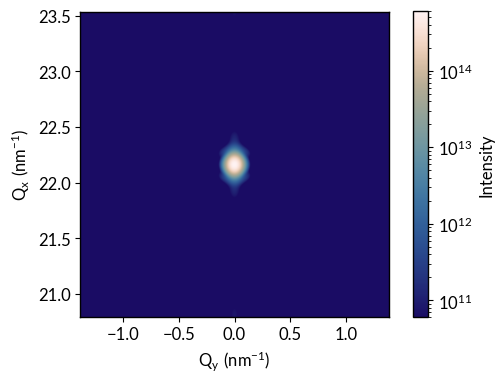

In [25]:
amplitude = simulator.calculate_supercell_scattering(q_vectors, supercell_size, mask=beam.profile, q_batch_size=q_batch_size)
intensity = (amplitude.abs() ** 2)
fig = detector.plot_intensity(intensity[0], q_vectors)